# Wine Club Data Analysis - Part 4: Sentiment Analysis

Thanks to Nate painstakingly entering in every comment we've written down about the wines over the years, we can likely correlate different descriptions of the wine with positive or negative ratings.

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'savefig.dpi' : 100})
sns.set_context("paper")
sns.set_style("darkgrid")
wines = pd.read_csv('wines.csv', index_col=0)
scores = pd.read_csv('scores.csv', index_col=0)
nights = pd.read_csv('nights.csv')

I'm going to use regular expressions to handle most of the word processing, and a cool python library called [word_cloud](https://github.com/amueller/word_cloud) to display the results.

In [258]:
import re
import string
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

Even though Nate went through the trouble of separating phrases with commas, Here I'm just picking out individual words. Most phrases don't get repeated more than once or twice in the whole dataset.

In [259]:
scores['split_comments'] = scores.Comments.str.lower().str.findall(r"\w[\w']*")

There may be more advanced ways to perform these basic functions, but for this purpose I just extend the python ```dict``` class to give me an easy way to aggregate the ratings on a word-by-word basis

In [260]:
class WordsDict(dict):
    
    def add_rating(self, rating):
              
        score = rating.Score
        for word in rating.split_comments:
            if word.isdigit():
                continue
            
            if word in STOPWORDS:
                continue
            
            
            self.add_word(word, score)
            
    def add_word(self, word, score):
        
        try: self[word] += [(score)]
        except KeyError: self[word] = [score]
            
            
    def combine_words(self, word_list):
        
        for word in word_list[1:]:
            self[word_list[0]] += self[word]
            del self[word]

There are also better ways to combine similar words, but our dataset is small enough to make this manual method relatively straightforward/painless.

In [261]:
word_scores = WordsDict()

scores_with_comments = scores[scores.split_comments.notnull()]

for i, entry in scores_with_comments.iterrows():
    word_scores.add_rating(entry)
    

manual_combinations = [
    ['acid', 'acidic', 'acidity'],
    ['berry', 'berries'],
    ['blueberry', 'blueberries'],
    ['cranberry', 'cran'],
    ['fruit', 'fruity'],
    ['jam', 'jammy'],
    ['juice', 'juicy'],
    ['oak', 'oaky'],
    ['pepper', 'peppery'],
    ['tannic', 'tannins'],
    ['wood', 'woody'],
    ['smell', 'smells'],
    ['spice', 'spices'],
    ['strawberry', 'strawberries'],
    ['taste', 'tastes'],
    ['vermouth', 'vermouthy'], # who the hell says 'vermouthy'?
    ]

for lists in manual_combinations: word_scores.combine_words(lists)
    
word_scores = pd.Series(word_scores)

Here's the key part where I decide what a 'good word' and a 'bad word' is. A word is deemed good or bad if more than 80% of the word's occurrances lie on one side of the median score (11). (And it occurs at least 3 times)

In [262]:
frequent_words = word_scores[word_scores.apply(len) >= 3]
good_words = frequent_words[frequent_words.apply(lambda x: np.percentile(x, 20))
                            > 11.].apply(len)
bad_words  = frequent_words[frequent_words.apply(lambda x: np.percentile(x, 80))
                            < 11.].apply(len)

from operator import itemgetter
item1 = itemgetter(1)

def convert_series(series):
    d3 = series.to_dict()
    words = sorted(d3.items(), key=item1, reverse=True)
    maximum = float(max(d3.values()))
    for i, (word, count) in enumerate(words):
        words[i] = word, count / maximum
    return words

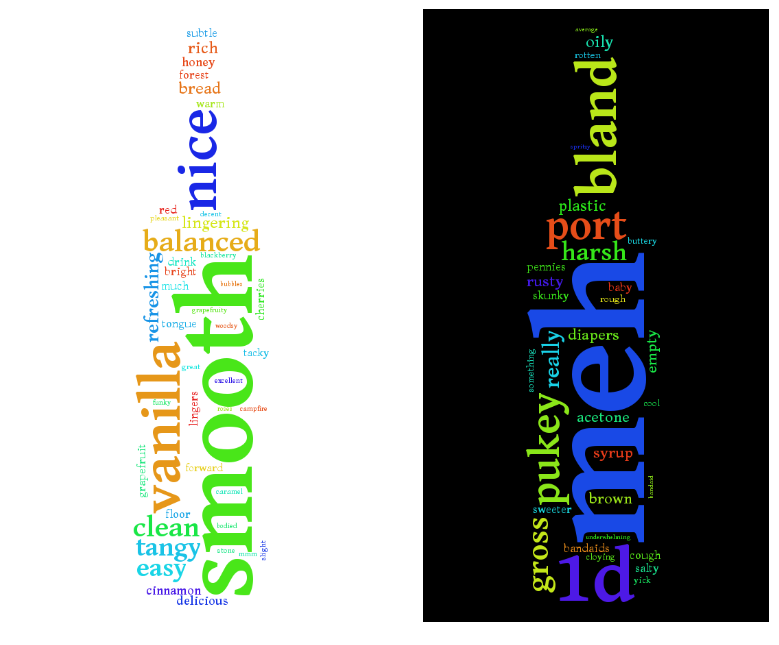

In [263]:
bottle_mask = imread("wine-bottle-mask.png", flatten=True)


wc_good = WordCloud(
    background_color="white", max_words=100, mask=bottle_mask,
    height=900, font_path="/usr/share/fonts/truetype/gentium-basic/GenBasB.ttf")
wc_good.fit_words(convert_series(good_words))

wc_bad = WordCloud(
    background_color="black", max_words=100, mask=bottle_mask,
    height=900, font_path="/usr/share/fonts/truetype/gentium-basic/GenBasB.ttf")
wc_bad.fit_words(convert_series(bad_words))


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(121)
ax.imshow(wc_good)
ax.axis("off")

ax = fig.add_subplot(122)
ax.imshow(wc_bad)
ax.axis("off")

plt.tight_layout()

plt.show()